In [1]:
import os
import sys

import polars as pl
import numpy as np
from tqdm import tqdm
from datetime import date, timedelta, datetime, timezone

from binance_utility.plot_utils import plot_correlation

In [2]:
# タイムバー1日分を読み込む。あらかじめgenerate_timebar.pyを使ってデータファイルをダウンロードしておくこと。
days = 120
symbol = "BTCUSDT"
last_date = (datetime.now(timezone.utc) - timedelta(days = 2)).date()
start_date = last_date - timedelta(days=days)
interval_sec = 1800

if "df_timebar" in globals():
    del df_timebar

df_timebar = None
date_cursor = start_date

while date_cursor <= last_date:
    if df_timebar is None:
        df_timebar = pl.read_parquet(f"/home/jovyan/work/binance_utility/timebar/{symbol}_TIMEBAR_{interval_sec:d}SEC_{date_cursor.year:04d}-{date_cursor.month:02d}-{date_cursor.day:02d}.parquet")
    else:
        df_timebar = df_timebar.vstack(pl.read_parquet(f"/home/jovyan/work/binance_utility/timebar/{symbol}_TIMEBAR_{interval_sec:d}SEC_{date_cursor.year:04d}-{date_cursor.month:02d}-{date_cursor.day:02d}.parquet"))
    date_cursor = date_cursor + timedelta(days=1)

df_timebar = df_timebar.with_columns([(pl.col("market_bid_volume") - pl.col("market_ask_volume")).alias("signed_volume")])

/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: divide by zero encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))
/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: invalid value encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


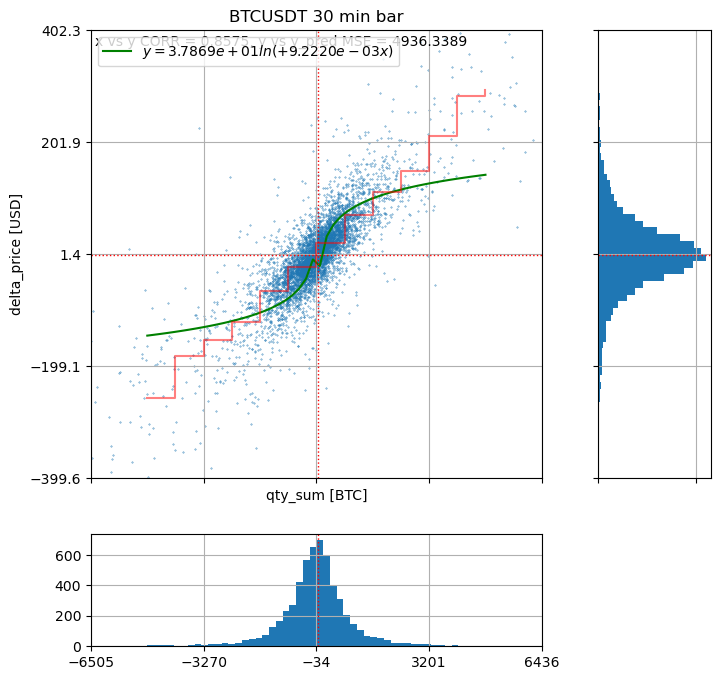

In [3]:
# タイムバーの売買インバランス対価格変化の散布図を作成し、後に使うパラメータb, cを計算する
# _popt[0]がb, _popt[1]がcに相当する
x = df_timebar["signed_volume"]
y = df_timebar["delta_price"]

def func(x, a, b):
    return np.where(np.abs(x) < 1, 0, np.sign(x) * a * np.log(b * np.abs(x)))
func_str = "$y = %s ln(%s x)$"

_popt, _pcov = plot_correlation(x, y, func=func, func_label=func_str, title=f"{symbol} {interval_sec // 60} min bar", xaxis_label="qty_sum [BTC]", yaxis_label="delta_price [USD]", legend_loc="best")
_b = _popt[0]
_c = _popt[1]

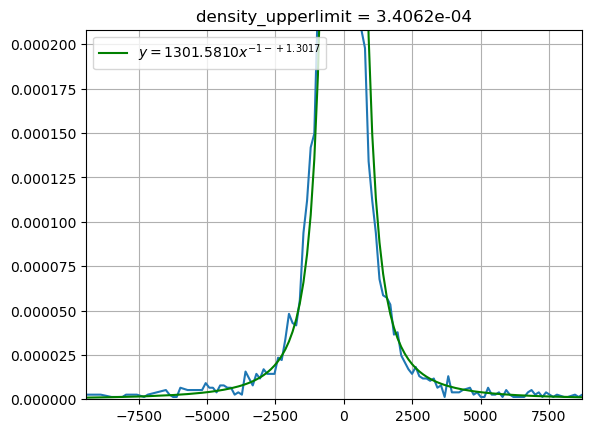

In [4]:
# タイムバーの売買インバランスの確率分布図を作成し、後に使うパラメータa, \alphaを計算する
# _popt[0]がa, _popt[1]が\alphaに相当する
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

array_histogram = np.histogram(df_timebar["signed_volume"], bins=256, density=True)
density_quantile = 0.90
density_upperlimit = np.quantile(array_histogram[0], density_quantile)
df_histogram = pl.DataFrame({"signed_volume": array_histogram[1][:-1], "density": array_histogram[0]}).filter(pl.col("density") > 0).filter(pl.col("density") < density_upperlimit)

def func(x, a, b):
    return a * np.power(np.abs(x), -1-b)
    
_popt, _pcov = curve_fit(func, df_histogram["signed_volume"], df_histogram["density"])

array_histogram = np.histogram(df_timebar["signed_volume"], bins=256, density=True)
density_upperlimit = np.quantile(array_histogram[0], 0.97)
df_histogram = pl.DataFrame({"signed_volume": array_histogram[1][:-1], "density": array_histogram[0]}).filter(pl.col("density") > 0).filter(pl.col("density") < density_upperlimit)
plt.plot(df_histogram["signed_volume"], df_histogram["density"])
plt.plot(df_histogram["signed_volume"], func(df_histogram["signed_volume"], *_popt), color = 'green', label = '$y = %s x^{-1 - %s}$' % (f'{_popt[0]:.4f}',  f'{_popt[1]:+.4f}'))

plt.ylim(0, df_histogram["density"].quantile(0.97))
plt.xlim(df_histogram["signed_volume"].quantile(0.1), df_histogram["signed_volume"].quantile(0.9))
plt.title(f"density_upperlimit = {density_upperlimit:.4e}")
plt.grid()
plt.legend()

_a = _popt[0]
_alpha = _popt[1]

$f^Q (x) = a\cdot x^{-1-\alpha}$

$$
a=0.3396702 \\
\alpha=0.14791845 \\
$$

$\Delta p = b\cdot\log(c\cdot Q)$

$$
b=11.11420511\\
c=0.05961304
$$

$\Lambda = \frac{1}{15 \cdot 60}$ (15分を基準時間とするため)

$$
\begin{aligned}
\lambda(\delta) &= \Lambda\cdot P(\Delta p > \delta)\\
&= \Lambda\cdot P(b\cdot\ln(c\cdot Q) > \delta)\\
&= \Lambda\cdot P\left(c\cdot Q > \exp\left(\frac{1}{b}\delta\right)\right)\\
&= \Lambda\cdot P\left(Q > \frac{1}{c}\exp\left(\frac{1}{b}\delta\right)\right)\\
&= \Lambda \int_{\frac{1}{c}\exp\left(\frac{1}{b}\delta\right)}^{\infty} a\cdot x^{-1-\alpha} dx\\
&= -\frac{\Lambda}{\alpha}\cdot a \left[x^{-\alpha}\right]_{\frac{1}{c}\exp\left(\frac{1}{b}\delta\right)}^{\infty}\\
&= -\frac{\Lambda}{\alpha}\cdot a \left[0 - \frac{1}{c}\exp\left(-\frac{\alpha}{b}\delta\right)\right]\\
&= \frac{\Lambda}{\alpha}\cdot\frac{a}{c}\exp\left(-\frac{\alpha}{b}\delta\right)\\
&= A\cdot\exp\left(-k\cdot\delta\right)\\
\end{aligned}
$$

In [5]:
# 各種定数
Lambda = 1 / (15 * 60)
a, alpha = [226.98638124, 1.1254549]
b, c = [3.0534806e+01, 1.2302710e-02]

# 定数から A exp(-k \delta)で利用するパラメータを計算
A = Lambda / alpha * a / c
k = alpha / b

gamma = 1
xi = gamma
delta = 1

def delta_b_delta_a(k, q, delta, sigma, A, gamma):
    return 2 / k + delta * np.sqrt((gamma * (sigma * np.sqrt(groupby_interval_min * 60)) ** 2 * np.e) / (2 * A * delta * k))
    
def delta_b_delta_a_with_xi(k, q, delta, sigma, A, gamma):
    return 2 / (xi * delta) * np.log(1 + (xi * delta) / k) + delta * np.sqrt((gamma * (sigma * np.sqrt(groupby_interval_min * 60)) ** 2) / (2 * A * delta * k) * np.power((1 + (xi * delta) / k), k / (xi * delta) + 1))

df_timebar = df_timebar.with_columns((delta_b_delta_a_with_xi(k, 0, delta, pl.col("estimated_sigma").shift(), A, gamma).alias("delta_b_delta_a_xi")))
df_timebar = df_timebar.with_columns((delta_b_delta_a(k, 0, delta, pl.col("estimated_sigma").shift(), A, gamma).alias("delta_b_delta_a"))).drop_nulls()
df_timebar

NameError: name 'groupby_interval_min' is not defined

OK Volatility Estimatorを使ってバーのボラティリティを推定する。

$$
\frac{0.811 (\text{High} - \text{Low}) - 0.369 |\text{Close} - \text{Open}|}{\sqrt{\text{Duration of the Trading Sessoion}}}
$$

In [ ]:
import pandas as pd
import mplfinance as mpf

df_timebar_pd = df_timebar.to_pandas()
df_timebar_pd["timestamp"] = pd.to_datetime(df_timebar_pd["timestamp"], unit="ms")
df_timebar_pd = df_timebar_pd.set_index("timestamp")
df_timebar_pd_filtered = df_timebar_pd[(df_timebar_pd.index >= "2023-5-05 12:00:00") & (df_timebar_pd.index <= "2023-5-06")]

apdict = [
    mpf.make_addplot(df_timebar_pd_filtered["Open"] + df_timebar_pd_filtered["delta_b_delta_a"] / 2, panel=0, color='red', linestyle=':', width=1, alpha=0.7),
    mpf.make_addplot(df_timebar_pd_filtered["Open"] - df_timebar_pd_filtered["delta_b_delta_a"] / 2, panel=0, color='green', linestyle=':', width=1, alpha=0.7)]

mpf.plot(df_timebar_pd_filtered, type='candle', addplot=apdict, volume=True, style='binance', figscale=1.0, figsize=(8, 6), title=f"Gamma = {gamma}")
plt.show()

KeyError: 'Open'

In [ ]:
plt.plot(df_timebar["timestamp"], df_timebar["open"], label="open")
plt.plot(df_timebar["timestamp"], df_timebar["close"], label="close")
plt.plot(df_timebar["timestamp"], df_timebar["open"] + df_timebar["delta_b_delta_a"] / 2, label="ask")
plt.plot(df_timebar["timestamp"], df_timebar["open"] - df_timebar["delta_b_delta_a"] / 2, label="bid")
plt.xlim(1678406400000, 1678406400000 + 15 * 60 * 1000 * 10)
plt.ylim(19500, 20500)
plt.legend()

ColumnNotFoundError: open